# Biblioteki i funkcja charakterystyk

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy.fft as fft
from  scipy.signal import butter, buttord
from  scipy.signal import lfilter, filtfilt
from  scipy.signal import iirnotch
from  scipy.signal import freqz, group_delay
from scipy import interpolate

In [ ]:
def charakterystyki(a,b,f,T,Fs, f_lim = None):
    if f_lim == None:
      f_lim = (0, Fs/2)
    # oś czasu
    t = np.arange(-T, T, 1/Fs)
  
    # obliczamy transmitancję; chcemy worN = f
    f, h = freqz(b,a,f,fs = Fs) 
    
    # obliczamy moduł transmitancji
    m = np.abs(h)
    
    # obliczamy fazę i "rozwijamy" ją   
    faza = np.unwrap(np.angle(h))
    w = 2*np.pi*f/Fs 
  
    # obliczamy opóźnienie grupowe
    ff, grupowe = group_delay((b, a), f,fs=Fs)
    
    # obliczamy odpowiedź impulsową
    x = np.zeros(len(t))
    x[len(t)//2] = 1 # impuls
    y = lfilter(b,a,x) # przepuszczamy impuls przez filtr i obserwujemy odpowiedź impulsową
    
    # obliczamy odpowiedź schodkową
    s = np.zeros(len(t))
    s[len(t)//2:] = 1 # schodek
    ys = lfilter(b,a,s) # przepuszczamy schodek przez filtr i obserwujemy odpowiedź schodkową
    
    fig = plt.figure()
    plt.subplot(2,2,1)
    plt.title('moduł transmitancji')
    M = 20*np.log10(m)
    plt.plot(f,M)
    plt.ylabel('[dB]')
    plt.grid('on')
    plt.xlim(f_lim)
    M_zoom = M[np.logical_and( f_lim[0]<f , f<f_lim[1])]
    plt.ylim((np.min(M_zoom), np.max(M_zoom)))
    
    plt.subplot(2,2,3)
    plt.title('opóźnienie grupowe')
    plt.plot(f,grupowe)
    plt.ylabel('probki')
    plt.xlabel('Częstość [Hz]')
    plt.grid('on')
    plt.xlim(f_lim)
    plt.ylim([np.min(grupowe)-1, np.max(grupowe)+1])
    
    plt.subplot(2,2,2)
    plt.title('odpowiedź impulsowa')
    plt.plot(t, x)
    plt.plot(t, y)
    plt.xlim([-T/4,T])
    plt.grid('on')
    
    plt.subplot(2,2,4)
    plt.title('odpowiedź schodkowa')
    plt.plot(t, s)
    plt.plot(t, ys)
    plt.xlim([-T/4,T])
    plt.xlabel('Czas [s]')
    plt.grid('on')
    
    fig.subplots_adjust(hspace=.5)
    plt.show()

# Wczytanie sygnałów


In [ ]:
n_ch = 3
sampling = 256

with open('Mikolaj_rs.raw', 'rb') as f_out:
    syg = np.fromfile(f_out, dtype='<f')
syg_spoczynek = np.reshape(syg,(len(syg)//n_ch,n_ch))
syg_spoczynek = 0.0715*syg_spoczynek
T_spoczynek = len(syg_spoczynek)/sampling

with open('Zosia_wf.raw', 'rb') as f_out:
    syg = np.fromfile(f_out, dtype='<f')
syg_zmeczenie = np.reshape(syg,(len(syg)//n_ch,n_ch))
syg_zmeczenie = 0.0715*syg_zmeczenie
T_zmeczenie = len(syg_zmeczenie)/sampling

with open('Mikolaj_horror.raw', 'rb') as f_out:
    syg = np.fromfile(f_out, dtype='<f')
syg_horror = np.reshape(syg,(len(syg)//n_ch,n_ch))
syg_horror = 0.0715*syg_horror
T_horror = len(syg_horror)/sampling

# Sprawdzenie charakterystyk różnych rzędów filtrów

Górnoprzepustowy

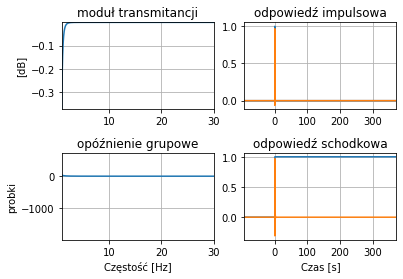

In [ ]:
b, a = signal.butter(3, 0.67, btype = 'highpass', fs = sampling)
charakterystyki(a, b, np.arange(0.01, sampling/2, 0.001), T_spoczynek, Fs=sampling, f_lim=(1,30))

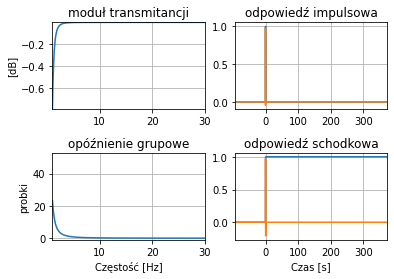

In [ ]:
b, a = signal.butter(2, 0.67, btype = 'highpass', fs = sampling)
charakterystyki(a, b, np.arange(0.01, sampling/2, 0.001), T_spoczynek, Fs=sampling, f_lim=(1,30))

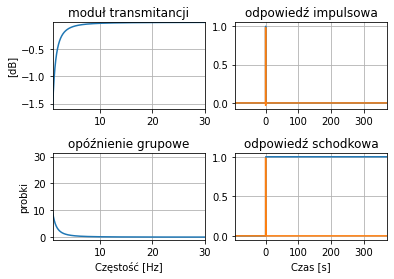

In [ ]:
b, a = signal.butter(1, 0.67, btype = 'highpass', fs = sampling)
charakterystyki(a, b, np.arange(0.01, sampling/2, 0.001), T_spoczynek, Fs=sampling, f_lim=(1,30))

Dolnoprzepustowy

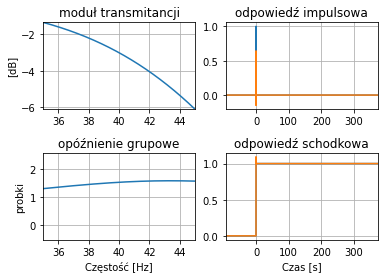

In [ ]:
b, a = signal.butter(2, 40, btype = 'lowpass', fs = sampling)
charakterystyki(a, b, np.arange(0.01, sampling/2, 0.001), T_spoczynek, Fs=sampling, f_lim=(35,45))

# Program do wstępnej obróbki (ćwiczenie 4)


Pobieranie i filtrowanie sygnału

In [ ]:
def getSignal(name, channels, sampling_rate):
  with open(name, 'rb') as f_out:
    syg = np.fromfile(f_out, dtype='<f')
  syg = np.reshape(syg,(len(syg)//channels,channels))
  syg = 0.0715*syg
  timeline = np.arange(0, len(syg)/sampling, 1/sampling)
  
  b, a = butter(3, 0.67, btype = 'highpass', fs = sampling_rate)
  syg = filtfilt(b, a, syg, axis = 0)
  
  b, a = butter(2, 40, btype = 'lowpass', fs = sampling_rate)
  syg = filtfilt(b, a, syg, axis = 0)

  b, a = iirnotch(50/128, 30, fs = 2.0 )
  syg = filtfilt(b, a, syg, axis = 0)
  return syg, timeline

Odprowadzenie Einthovena

In [ ]:
def getEinthoven(syg):
  LR = syg[:,0]
  PR = syg[:,1]
  LN = syg[:,2]

  I = LR - PR
  II = LN - PR
  III = LN - LR
  return I, II, III

Odprowadzenie Goldberga

In [ ]:
def getGoldberg(syg):
  LR = syg[:,0]
  PR = syg[:,1]
  LN = syg[:,2]
  
  a_Vl = LR - (PR + LN)/2
  a_Vr = PR - (LR + LN)/2
  a_Vf = LN - (LR + PR)/2
  return a_Vl, a_Vr, a_Vf

Wykresy odprowadzeń (nie znalazłem uniwersalnej nazwy angielskiej, więc nazwa kreatywna plotOdprowadzenia)

In [ ]:
def plotOdprowadzenia(name, channels, sampling_rate, start=0, end=0):
  syg, timeline = getSignal(name, channels, sampling_rate)
  titles_einthoven = ['I Einthovena','II Einthovena', 'III Einthovena']
  titles_goldberg = ['a_Vl Goldberga', 'a_Vr Goldberga', 'a_Vf Goldberga']

  i, ii, iii = getEinthoven(syg)
  vl, vr, vf = getGoldberg(syg)
  iter = zip([i, ii, iii], [vl, vr, vf])

  if end == 0:
    end = len(syg)/sampling

  fig = plt.figure(figsize=(30,10))
  plot_index = 1
  for numer, (i, j) in enumerate(iter):
    ax = fig.add_subplot(3, 2, plot_index)
    ax.plot(timeline, i)
    ax.grid()
    ax.set_xlim(start,end)
    ax.title.set_text(name+', '+titles_einthoven[numer])
    ax = fig.add_subplot(3, 2, plot_index+1)
    ax.plot(timeline, j)
    ax.grid()
    ax.title.set_text(name+', '+titles_goldberg[numer])
    ax.set_xlim(start,end)
    plot_index += 2
  fig.show()

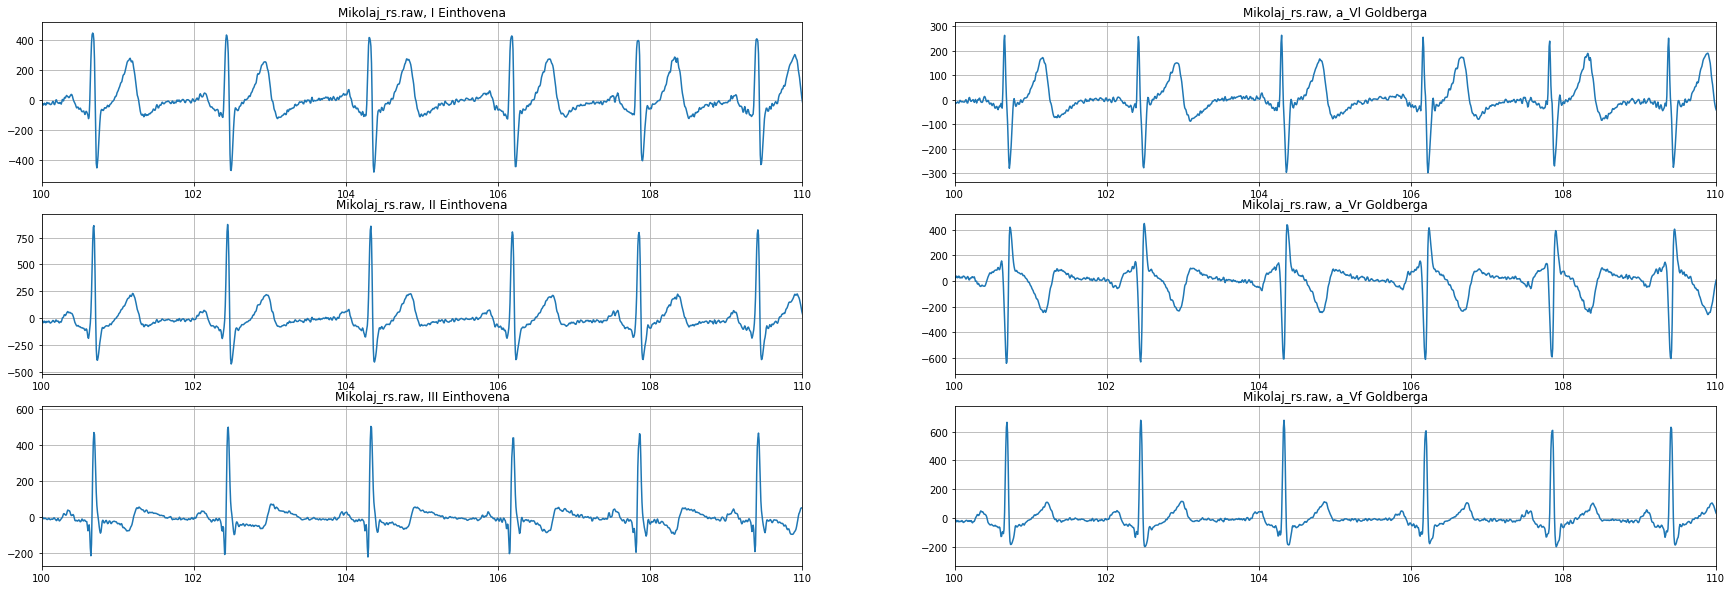

In [ ]:
plotOdprowadzenia('Mikolaj_rs.raw', 3, sampling, start=100, end=110)

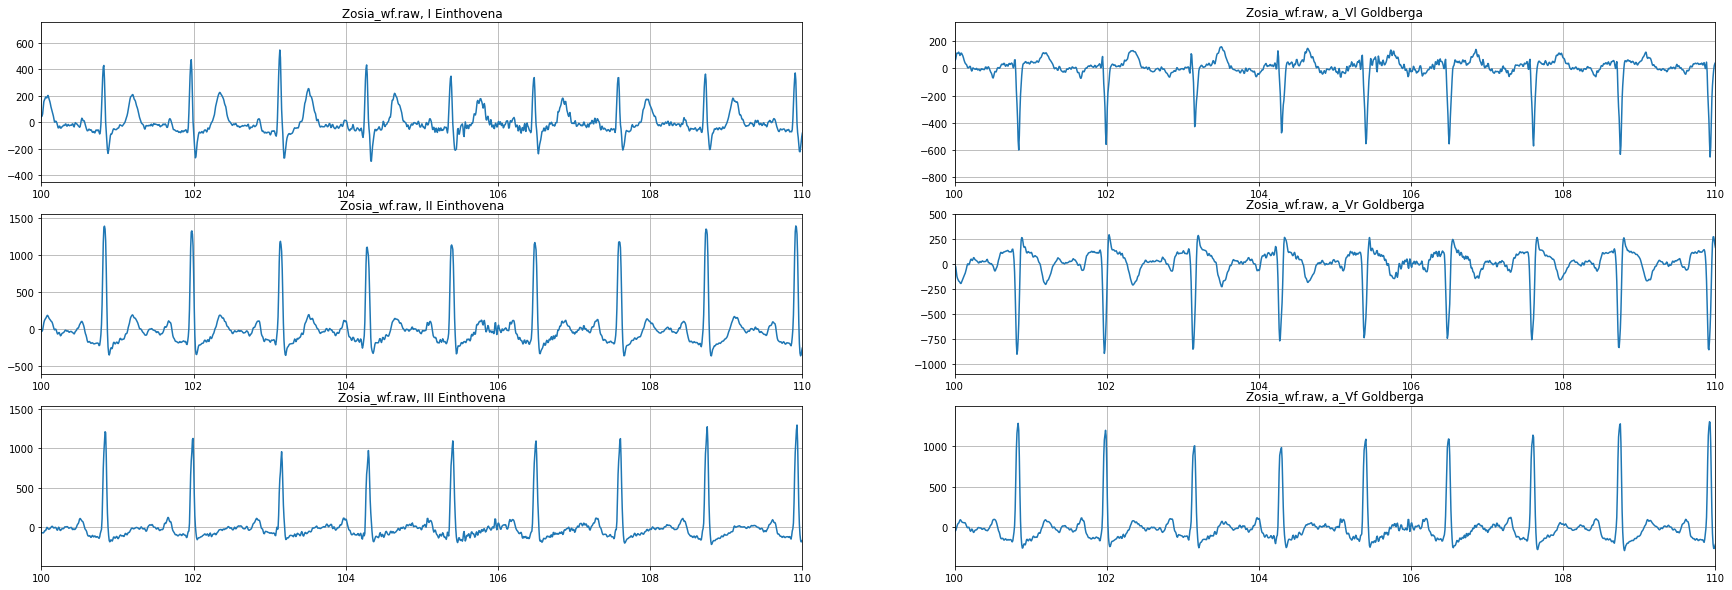

In [ ]:
plotOdprowadzenia('Zosia_wf.raw', 3, sampling, start=100, end=110)

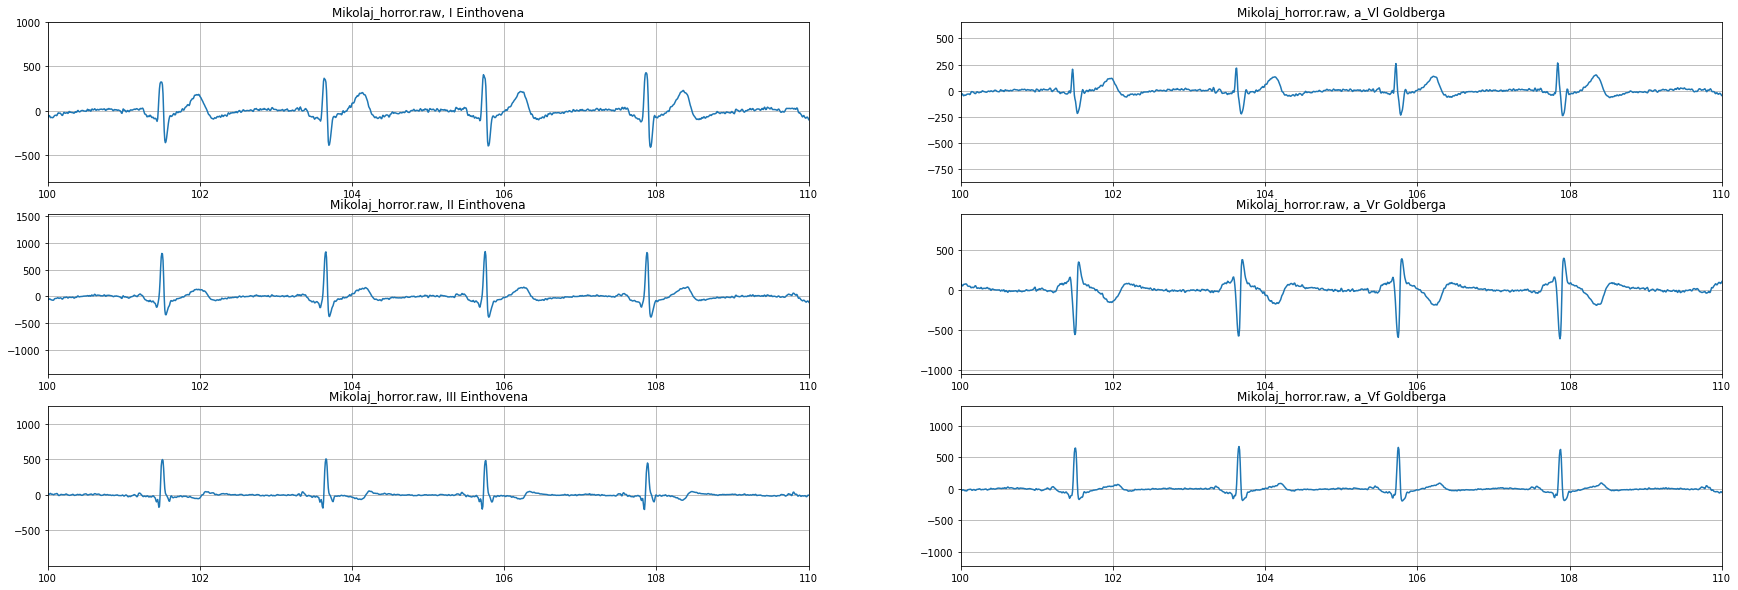

In [ ]:
plotOdprowadzenia('Mikolaj_horror.raw', 3, sampling, start=100, end=110)

# Szukanie pików R

Zaczynamy od histogramów, żeby było wiadomo jakie cechy mają piki i jakie wybrać argumenty dla szukania pików R

In [ ]:
def getHistograms(name, channels, sampling_rate):
  syg, timeline = getSignal(name, channels, sampling_rate)
  i, ii, iii = getEinthoven(syg)
  peaks, properties = signal.find_peaks(ii, height = 0, threshold = 0, distance = 1, prominence = (0.5, None), width = 0)

  fig = plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)
  plt.hist(properties['peak_heights'], edgecolor='black')
  plt.title('Histogram wysokości')
  plt.subplot(1,2,2)
  plt.hist(properties['width_heights'], edgecolor='black')
  plt.title('Histogram szerokości')
  plt.suptitle('Histogramy cech pików dla '+name)

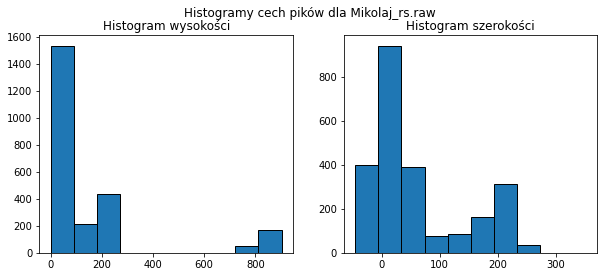

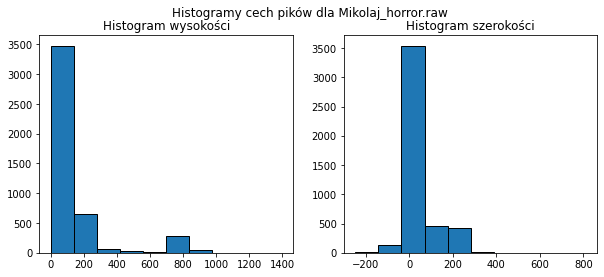

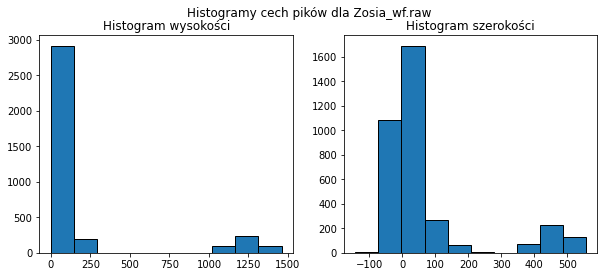

In [ ]:
getHistograms('Mikolaj_rs.raw', 3, sampling)
getHistograms('Mikolaj_horror.raw', 3, sampling)
getHistograms('Zosia_wf.raw', 3, sampling)

Wykrywanie i zaznaczanie opisanych histogramami pików

In [ ]:
def plotPeaks(name, channels, sampling, start=0, end=0):
  syg, timeline = getSignal(name, channels, sampling)
  i, ii, iii = getEinthoven(syg)
  peaks, properties = signal.find_peaks(ii, height = 420, threshold = 0, distance = 1, prominence = (0.5, None), width = 0)
  if end == 0:
    end = len(ii)/sampling
  
  fig=plt.figure(figsize=(20, 5))
  plt.plot(ii)
  plt.plot(peaks, ii[peaks], "x")
  plt.xlabel('Czas[s]')
  plt.ylabel('Amplituda')
  plt.xlim(start*sampling, end*sampling)
  plt.grid()
  plt.title('')
  plt.show()

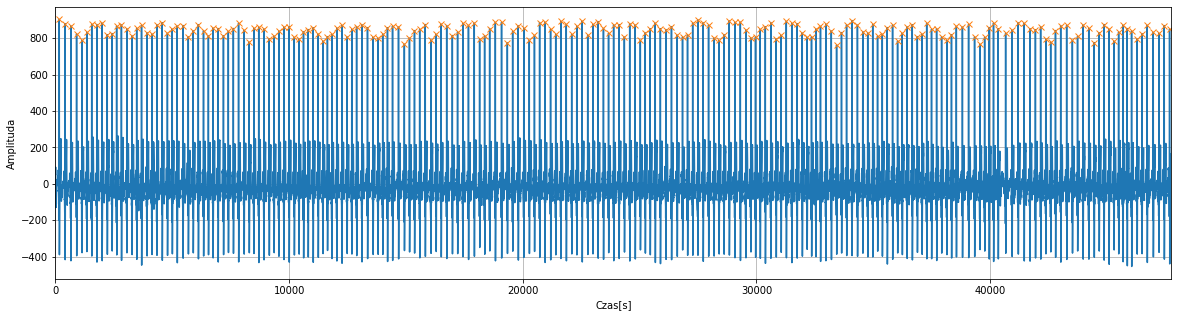

In [ ]:
plotPeaks('Mikolaj_rs.raw', 3, sampling)

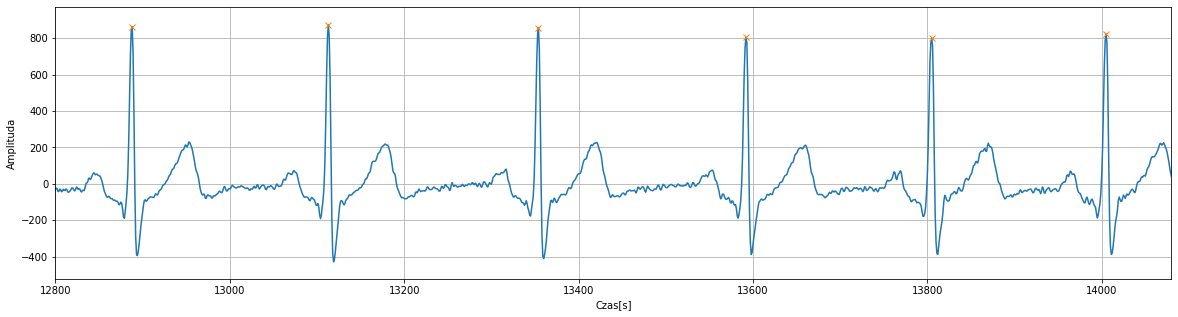

In [ ]:
plotPeaks('Mikolaj_rs.raw', 3, sampling, 100, 110)

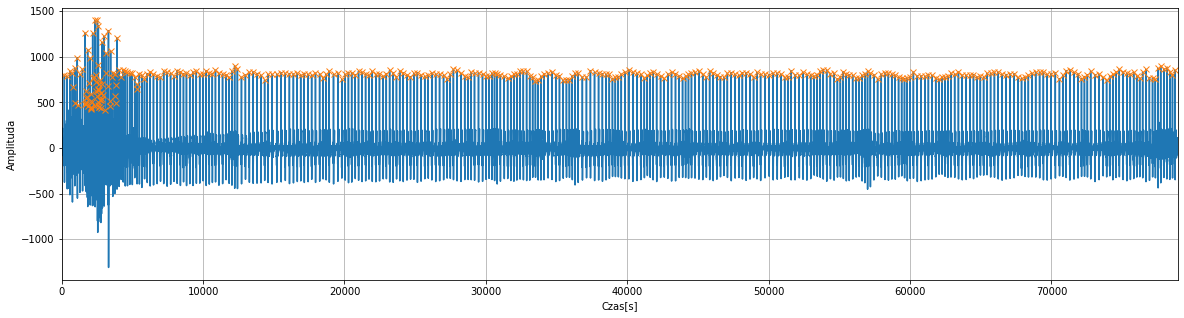

In [ ]:
plotPeaks('Mikolaj_horror.raw', 3, sampling)

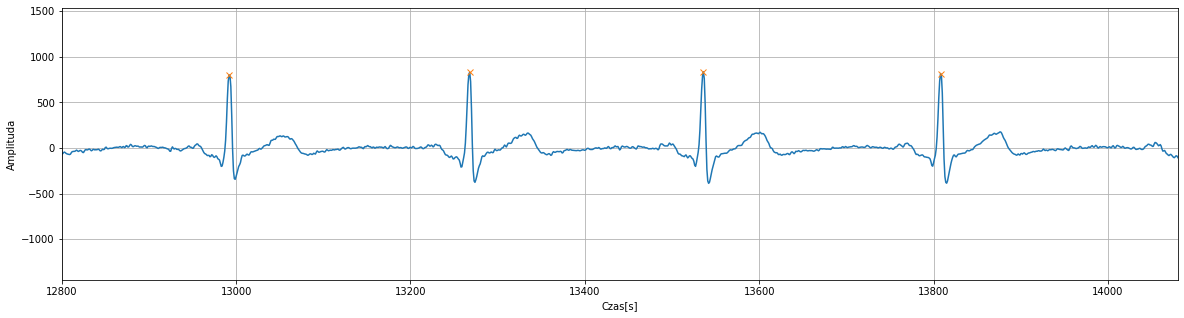

In [ ]:
plotPeaks('Mikolaj_horror.raw', 3, sampling, 100, 110)

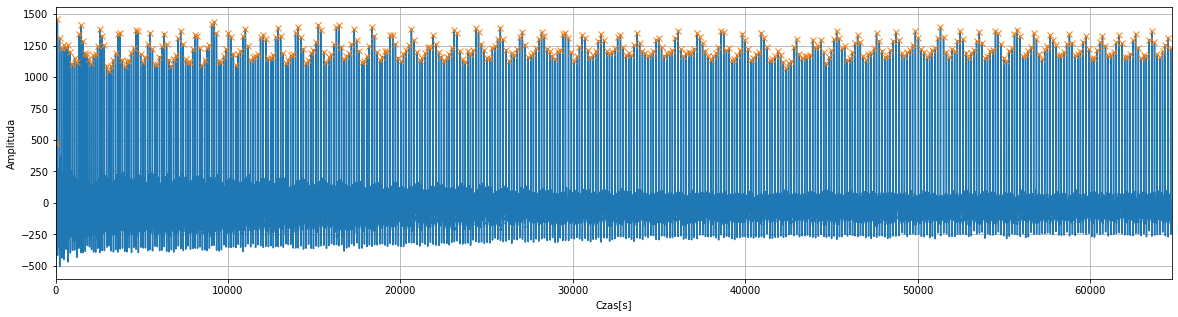

In [ ]:
plotPeaks('Zosia_wf.raw', 3, sampling)

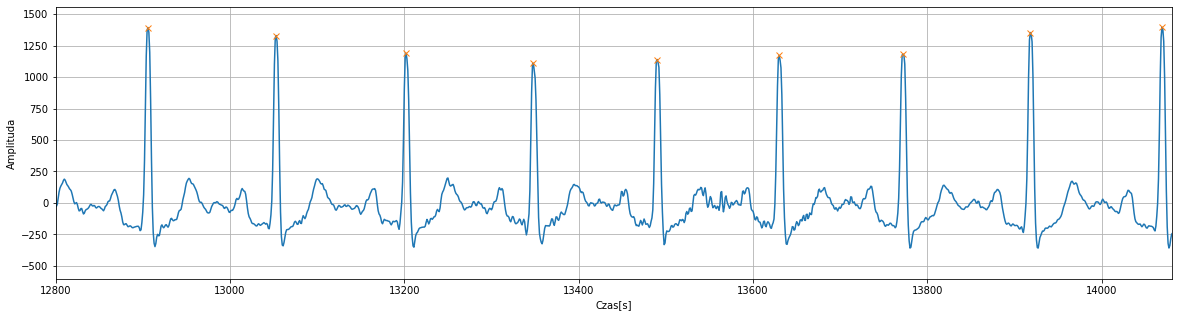

In [ ]:
plotPeaks('Zosia_wf.raw', 3, sampling, 100, 110)

# Tętno
Szukamy odległości w próbkach pików i liczymy ile daje to czasu w sekundach, mnożąc to *60 dostajemy tętno.

In [ ]:
def getPeaks(name, channels, sampling_rate):
  syg, timeline = getSignal(name, channels, sampling_rate)
  i, ii, iii = getEinthoven(syg)
  peaks, properties = signal.find_peaks(ii[10000:], height = 420, threshold = 0, distance = 1, prominence = (0.5, None), width = 0)
  return peaks

def plotHeartRate(name, channels, sampling_rate):
  peaks = getPeaks(name, channels, sampling_rate)
  diff = np.diff(peaks)
  time_diff = diff/sampling_rate
  hr = 1/time_diff*60
  plt.figure(figsize=(14, 4))
  plt.plot(peaks[:-1]/sampling_rate, hr)
  plt.grid()
  plt.title(name+', wykres średniego tętna | średnia z tętna dla całego wykresu: '+str(round(np.mean(hr),2)))
  plt.show()

def getHeartRate(name, channels, sampling_rate):
  peaks = getPeaks(name, channels, sampling_rate)
  diff = np.diff(peaks)
  time_diff = diff/sampling_rate
  hr = 1/time_diff*60
  return peaks[:-1], hr, time_diff

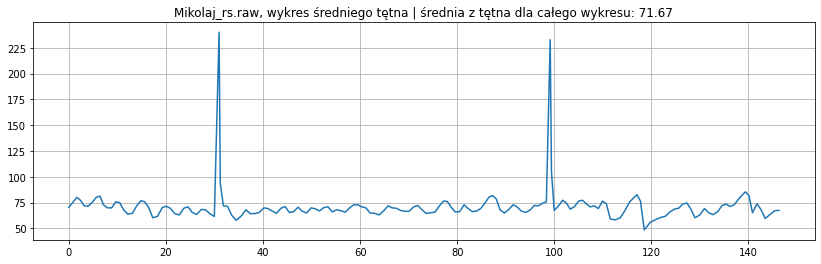

In [ ]:
plotHeartRate('Mikolaj_rs.raw', 3, 256)

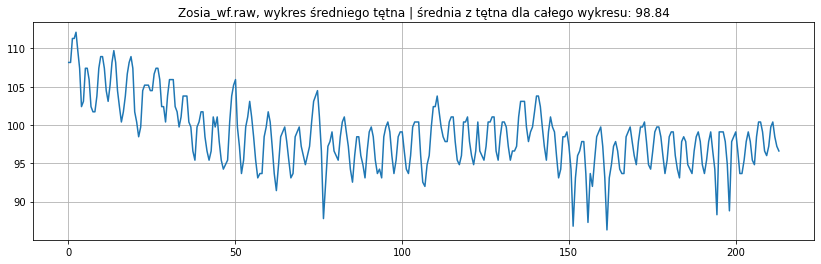

In [ ]:
plotHeartRate('Zosia_wf.raw', 3, 256)

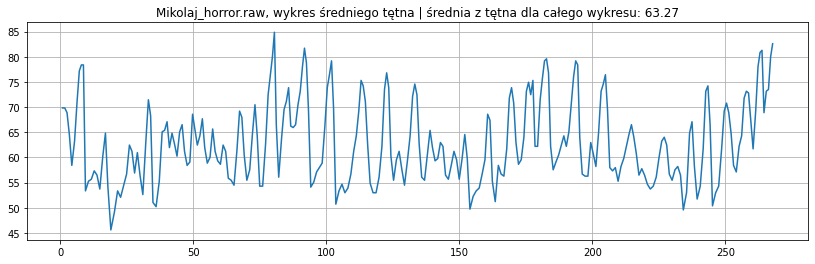

In [ ]:
plotHeartRate('Mikolaj_horror.raw', 3, 256)

# Widmo z odprowadzeń Goldberga
Transformata Fouriera dla kolejnych kanałów odprowadzenia Goldberga

In [ ]:
def getSpectrum(syg, length, sampling_rate):
  S = fft.rfft(syg,length)
  F = fft.rfftfreq(length, 1/sampling_rate)
  return np.real(S*S.conj()), np.real(F)

def plotSpectrum(name, channels, sampling_rate, start, f_min=0, f_max=0):
  titles = ['a_Vl', 'a_Vr', 'a_Vf']
  if f_max == 0:
    f_max = sampling_rate/2
  syg, timeline = getSignal(name, channels, sampling_rate)
  syg = syg[start*sampling_rate:(start+60)*sampling_rate]
  vl, vr, vf = getGoldberg(syg)

  fig = plt.figure(figsize=(24,6))
  for numer, i in enumerate([vl, vr, vf]):
    ax = fig.add_subplot(1,3,numer+1)
    S, F = getSpectrum(i, len(i), sampling_rate)
    ax.plot(F, S)
    ax.title.set_text('Widmo kanału '+titles[numer]+' odprowadzenia Goldberga')
    ax.set_xlim(f_min, f_max)
  fig.suptitle(name)
  fig.show()

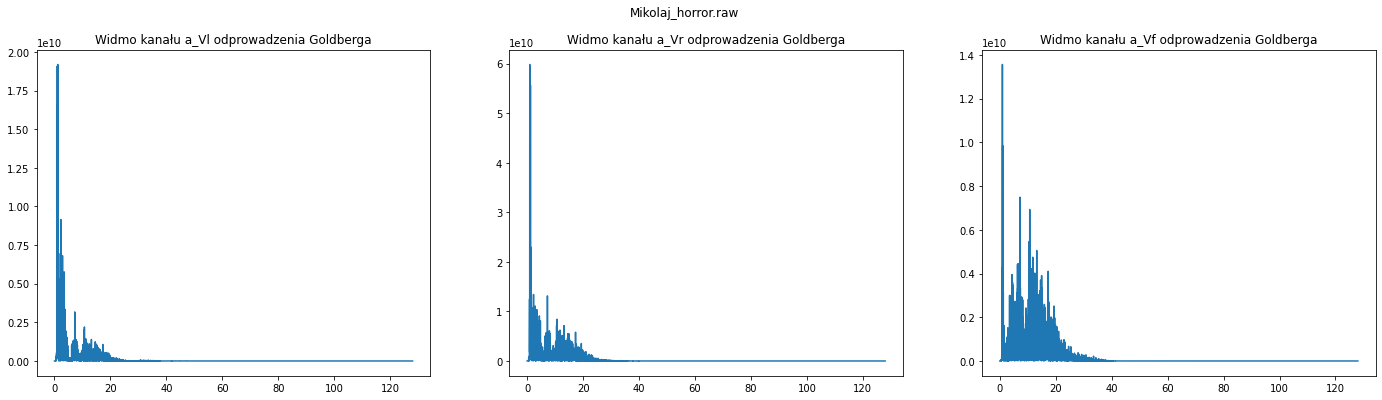

In [ ]:
plotSpectrum('Mikolaj_horror.raw', 3, 256, 100)

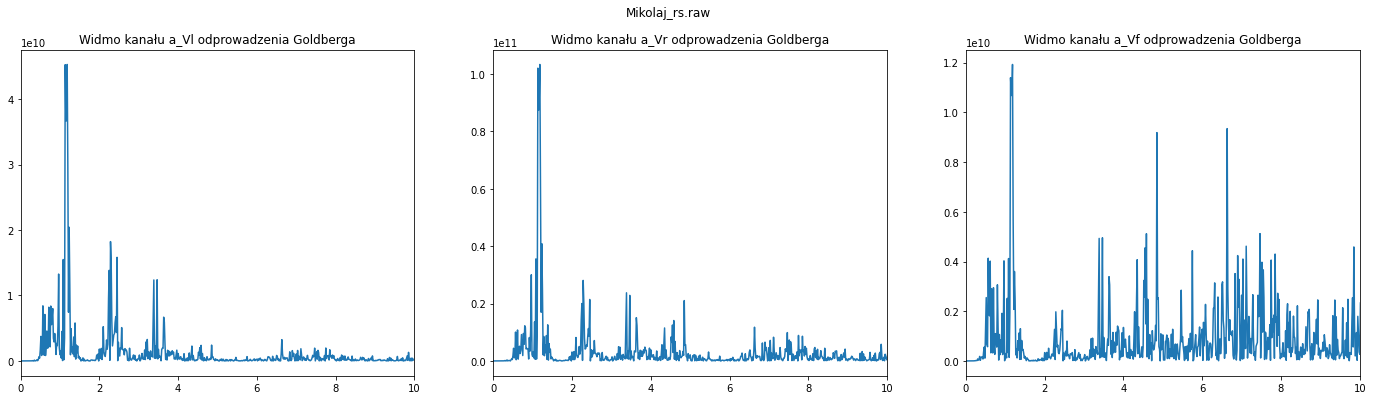

In [ ]:
plotSpectrum('Mikolaj_rs.raw', 3, 256, 100, 0, 10) # Przybliżenie na 0 - 10 Hz